# 算术式预测

## 首先，导入必要的模块

In [1]:
import numpy as np
import torch
 
import torchvision.datasets
# 导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# 导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

## 定义超参数

In [2]:
train_batch_size = 60   #每批处理的训练集数据
test_batch_size = 100   #每批处理的测试集数据
learning_rate = 0.01    #学习率
num_epoches = 20        #训练数据集的轮次
lr = 0.01               #学习率
momentum = 0.5          #动量

## 加载及预处理数据

In [3]:
# 构建 transform, 对图像做处理
transform = transforms.Compose([
    transforms.ToTensor(),              # 将图片转换为tensor
    transforms.Normalize([0.5], [0.5])  # 正则化，降低模型复杂度
])

#训练集
train_dataset = torch.load("datasets_arithmetic/arithmetic_train.pt")
a = torch.zeros(28, 84)  # 28 * 84 的全为零元素的张量
for i in range(60000):
    b = torch.cat((a, train_dataset[i][0], a))      # 用 0 填充，使图片形状为 84*84
    b = torch.tensor(b, dtype=torch.uint8)          # 转换为 uint8 格式
    train_dataset[i] = (b,) + train_dataset[i][1:]  # 替代原来的数据
    
#测试集
test_dataset = torch.load("datasets_arithmetic/arithmetic_test.pt")
for i in range(10000):
    b = torch.cat((a, test_dataset[i][0], a))      # 用 0 填充，使图片形状为 84*84
    b = torch.tensor(b, dtype=torch.uint8)         # 转换为 uint8 格式
    test_dataset[i] = (b,) + test_dataset[i][1:]   # 替代原来的数据
    
    
#加载数据
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

C:\Users\Sion\AppData\Local\Temp/ipykernel_4176/2701498331.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(b, dtype=torch.uint8)          # 转换为 uint8 格式
C:\Users\Sion\AppData\Local\Temp/ipykernel_4176/2701498331.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(b, dtype=torch.uint8)         # 转换为 uint8 格式


In [4]:
train_dataset[0] # 训练集第一个元素

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 5)

In [5]:
train_dataset[0][0].size()  # 输入网络的图片大小为 84*84

torch.Size([84, 84])

## 可视化源数据

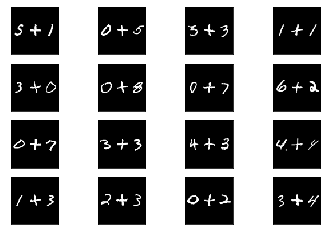

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# 抽取 16 张手写数字图片
fig = plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(example_data[i], cmap='gray', interpolation='none') # 显示图片
    plt.xticks([])
    plt.yticks([])

## 构建模型 (LeNet-5网络)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1个输入图片通道，6个输出通道，5*5的卷积核，步长为 1，padding填充为 0
        self.conv1 = nn.Conv2d(1, 6, 5, 1, 0)    # 输出形状为 80*80 (84-5+1)
        # max pooling, 2*2
        self.pool1 = nn.MaxPool2d(2, 2)          # 输出形状为 40*40
        # 6个输入图片通道，16个输出通道，5*5的卷积核，步长为 1，padding填充为 0
        self.conv2 = nn.Conv2d(6, 16, 5, 1, 0)   # 输出形状为 36*36 (40-5+1)
        # max pooling, 2*2
        self.pool2 = nn.MaxPool2d(2, 2)          # 输出形状为 18*18
        # 拉伸成一维向量，全连接层
        self.fc1 = nn.Linear(16 * 18 * 18, 120)
        # 全连接层
        self.fc2 = nn.Linear(120, 84)
        # 全连接层，输出层 Softmax，10 个数字
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x)) # 用relu函数激活经过第一层卷积的结果
        x = self.pool1(x)         # 第一个池化层
        x = F.relu(self.conv2(x)) # 用relu函数激活经过第二层卷积的结果
        x = self.pool2(x)         # 第二个池化层
        # 拉伸成一维向量
        x = x.view(-1, 16 * 18 * 18)  # -1 代表自动判断维数
        x = F.relu(self.fc1(x))   # 激活第一个全连接层
        x = F.relu(self.fc2(x))   # 激活第二个全连接层
        x = self.fc3(x)           # 输出层
        return x  

## 实例化网络

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 实例化网络
net = Net()
net = net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5184, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 定义损失函数

In [9]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)  # 优化器，用于更新参数

## 训练模型

In [10]:
cost = []  # 损失函数累加
net.train()
for epoch in range(num_epoches):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # 输入样本和标签
        inputs, labels = data[0],data[1]
        inputs = inputs.view(train_batch_size, -1, 84, 84)  #转化为 4 维，第 2 维自动判断
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 每次训练梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        outputs = net(inputs.float())  # 这里的输入是 4 维的
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        optimizer.step()
        # 记录误差
        running_loss += loss.item()
        # 打印训练情况
        if (i+1) % 1000 == 0:
            print("[epoch: %d, mini-batch: %5d] loss: %.3f" % 
                  (epoch + 1, i + 1, running_loss / 1000))  # 每训练 1000 个样本打印一次平均误差
            cost.append(running_loss / 1000)
            running_loss = 0.0

[epoch: 1, mini-batch:  1000] loss: 1.019
[epoch: 2, mini-batch:  1000] loss: 0.204
[epoch: 3, mini-batch:  1000] loss: 0.125
[epoch: 4, mini-batch:  1000] loss: 0.091
[epoch: 5, mini-batch:  1000] loss: 0.070
[epoch: 6, mini-batch:  1000] loss: 0.058
[epoch: 7, mini-batch:  1000] loss: 0.047
[epoch: 8, mini-batch:  1000] loss: 0.044
[epoch: 9, mini-batch:  1000] loss: 0.038
[epoch: 10, mini-batch:  1000] loss: 0.032
[epoch: 11, mini-batch:  1000] loss: 0.035
[epoch: 12, mini-batch:  1000] loss: 0.027
[epoch: 13, mini-batch:  1000] loss: 0.020
[epoch: 14, mini-batch:  1000] loss: 0.024
[epoch: 15, mini-batch:  1000] loss: 0.017
[epoch: 16, mini-batch:  1000] loss: 0.020
[epoch: 17, mini-batch:  1000] loss: 0.019
[epoch: 18, mini-batch:  1000] loss: 0.021
[epoch: 19, mini-batch:  1000] loss: 0.020
[epoch: 20, mini-batch:  1000] loss: 0.012


## 可视化训练及测试损失值

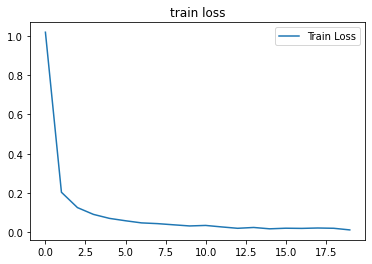

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('train loss')
plt.plot(np.arange(len(cost)), cost)
plt.legend(['Train Loss'], loc='upper right')

## 测试模型

### 验证模型在训练集上的效果

In [12]:
correct = 0  # 预测正确的个数
total = 0    # 总样本个数

with torch.no_grad(): # 关闭梯度
    for data in train_loader:
        inputs, labels = data
        inputs = inputs.view(train_batch_size, -1, 84, 84)
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs.float())
        _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
        total += labels.size(0)                   # 总样本个数加 1
        correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1

print("训练集上的准确率：%.3f" % (correct / total))

训练集上的准确率：0.996


### 验证模型在测试集上的效果

In [13]:
correct = 0  # 预测正确的个数
total = 0    # 总样本个数

with torch.no_grad(): # 关闭梯度
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.view(test_batch_size, -1, 84, 84)
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs.float())
        _, pred = torch.max(outputs.data, 1)      # 选取最大概率的那个标签为预测结果
        total += labels.size(0)                   # 总样本个数加 1
        correct += (pred == labels).sum().item()  # 如果预测正确，correct加 1

print("测试集上的准确率：%.3f" % (correct / total))

测试集上的准确率：0.977


# 实验总结

## 本次实验采用手写算术式为样本集，对运算结果进行预测。使用 60000 个样本作为训练集，使用 10000 个样本作为测试集。通过构建卷积神经网络模型(LeNet-5)，通过 Dataloader 将样本分批进行训练，训练集上每批处理 60 个样本数据，测试集上每批处理 100 个样本数据。迭代 20 次后，模型在训练集上的准确率为 0.996，在测试集上的准确率为 0.977。
